In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import joblib


In [20]:
df = pd.read_csv(r"C:\Users\samri\cod\git\Farmer\Machine_Learning\AI Prices Mandi Predictor\Agriculture_price_dataset.csv")

# Convert price date to datetime
df['Price Date'] = pd.to_datetime(df['Price Date'])
df['Year'] = df['Price Date'].dt.year
df['Month'] = df['Price Date'].dt.month
df['Day'] = df['Price Date'].dt.day
df['DayOfWeek'] = df['Price Date'].dt.dayofweek
df['WeekOfYear'] = df['Price Date'].dt.isocalendar().week

# Season mapping
def month_to_season(month):
    if month in [12,1,2]: return 'Winter'
    elif month in [3,4,5]: return 'Spring'
    elif month in [6,7,8]: return 'Summer'
    else: return 'Autumn'

df['Season'] = df['Month'].apply(month_to_season)
le_season = LabelEncoder()
df['Season_enc'] = le_season.fit_transform(df['Season'])

In [21]:
categorical_cols = ['STATE', 'District Name', 'Market Name', 'Commodity', 'Variety', 'Grade']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [23]:
df = df.sort_values(['Commodity', 'Market Name', 'Price Date'])

# Create 3-day lag features for Min, Max, Modal prices
for lag in range(1,4):
    df[f'Min_Price_lag{lag}'] = df.groupby(['Commodity','Market Name'])['Min_Price'].shift(lag)
    df[f'Max_Price_lag{lag}'] = df.groupby(['Commodity','Market Name'])['Max_Price'].shift(lag)
    df[f'Modal_Price_lag{lag}'] = df.groupby(['Commodity','Market Name'])['Modal_Price'].shift(lag)

# Drop rows with NaN after creating lag features
df = df.dropna().reset_index(drop=True)

In [24]:
features = ['STATE','District Name','Market Name','Commodity','Variety','Grade',
            'Year','Month','Day','DayOfWeek','WeekOfYear','Season_enc',
            'Min_Price_lag1','Min_Price_lag2','Min_Price_lag3',
            'Max_Price_lag1','Max_Price_lag2','Max_Price_lag3',
            'Modal_Price_lag1','Modal_Price_lag2','Modal_Price_lag3']

targets = ['Min_Price','Max_Price','Modal_Price']

X = df[features]
y = df[targets]

# Train-test split (time-based split recommended)
train_size = int(0.8 * len(df))
X_train, X_val = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_val = y.iloc[:train_size], y.iloc[train_size:]

In [26]:
from xgboost import XGBRegressor

models = {}
for target in targets:
    xgb_reg = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    # Fit without early stopping
    xgb_reg.fit(X_train, y_train[target], eval_set=[(X_val, y_val[target])], verbose=50)
    models[target] = xgb_reg


[0]	validation_0-rmse:1764.55187
[50]	validation_0-rmse:1309.79854
[100]	validation_0-rmse:1446.10020
[150]	validation_0-rmse:1458.71464
[200]	validation_0-rmse:1474.75372
[250]	validation_0-rmse:1485.49347
[300]	validation_0-rmse:1500.86636
[350]	validation_0-rmse:1507.30435
[400]	validation_0-rmse:1516.09337
[450]	validation_0-rmse:1520.68441
[500]	validation_0-rmse:1521.16342
[550]	validation_0-rmse:1529.28060
[600]	validation_0-rmse:1534.29720
[650]	validation_0-rmse:1537.17823
[700]	validation_0-rmse:1541.10317
[750]	validation_0-rmse:1543.71933
[800]	validation_0-rmse:1546.62452
[850]	validation_0-rmse:1550.43199
[900]	validation_0-rmse:1551.94353
[950]	validation_0-rmse:1554.40806
[999]	validation_0-rmse:1557.60727
[0]	validation_0-rmse:2055.50997
[50]	validation_0-rmse:1016.55336
[100]	validation_0-rmse:1056.37989
[150]	validation_0-rmse:1107.79440
[200]	validation_0-rmse:1156.84753
[250]	validation_0-rmse:1178.31954
[300]	validation_0-rmse:1193.55294
[350]	validation_0-rmse:12

In [31]:
import xgboost as xgb
import joblib

models = {}
for target in targets:
    dtrain = xgb.DMatrix(X_train, label=y_train[target])
    dval = xgb.DMatrix(X_val, label=y_val[target])

    params = {
        "objective": "reg:squarederror",
        "max_depth": 8,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42,
    }

    evals = [(dtrain, "train"), (dval, "eval")]

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=50
    )

    models[target] = model
    joblib.dump(model, f"C:\\Users\\samri\\cod\\git\\Farmer\\Machine_Learning\\AI Prices Mandi Predictor\\aimandi_predictor_{target}.pkl")
    print(f"Saved best {target} model!")


[0]	train-rmse:1856.52148	eval-rmse:1764.55187
[50]	train-rmse:607.20581	eval-rmse:1309.79854
[77]	train-rmse:478.99668	eval-rmse:1359.01892
Saved best Min_Price model!
[0]	train-rmse:2060.91055	eval-rmse:2055.50997
[50]	train-rmse:797.87134	eval-rmse:1016.55336
[98]	train-rmse:587.46029	eval-rmse:1055.14346
Saved best Max_Price model!
[0]	train-rmse:1945.93078	eval-rmse:1891.73328
[50]	train-rmse:651.59830	eval-rmse:930.71902
[93]	train-rmse:466.58019	eval-rmse:1020.04014
Saved best Modal_Price model!


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import joblib

# Split your data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert test data to DMatrix
dtest = xgb.DMatrix(X_test)

# Load trained models
loaded_models = {}
for target in targets:
    loaded_models[target] = joblib.load(
        f"C:\\Users\\samri\\cod\\git\\Farmer\\Machine_Learning\\AI Prices Mandi Predictor\\aimandi_predictor_{target}.pkl"
    )

# Make predictions on the test set
predictions = {}
for target in targets:
    model = loaded_models[target]
    predictions[target] = model.predict(dtest)

# Evaluate predictions
for target in targets:
    y_true = y_test[target]
    y_pred = predictions[target]
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{target} -> MSE: {mse:.2f}, MAE: {mae:.2f}")

# Optional: check first 5 predictions
for target in targets:
    print(f"Predictions for {target} (first 5): {predictions[target][:5]}")


Min_Price -> MSE: 481098.97, MAE: 185.89
Max_Price -> MSE: 437919.52, MAE: 189.44
Modal_Price -> MSE: 347377.11, MAE: 173.84
Predictions for Min_Price (first 5): [1710.0082 2391.2786 1400.6742 1715.6436 1169.975 ]
Predictions for Max_Price (first 5): [1812.7029 2657.9805 1434.7936 5281.1245 1393.688 ]
Predictions for Modal_Price (first 5): [1752.0874 2504.119  1417.7811 5292.8506 1293.9454]


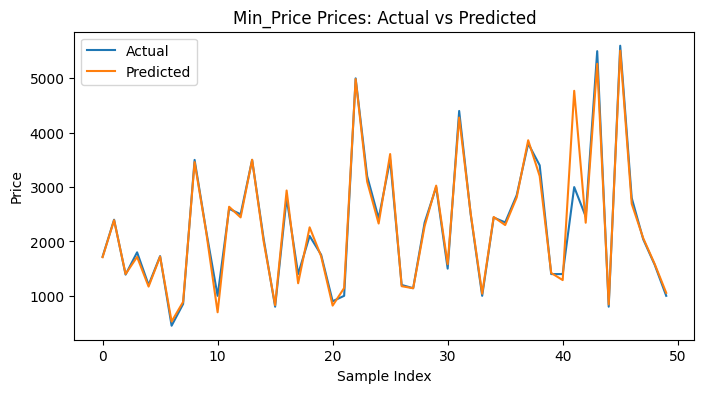

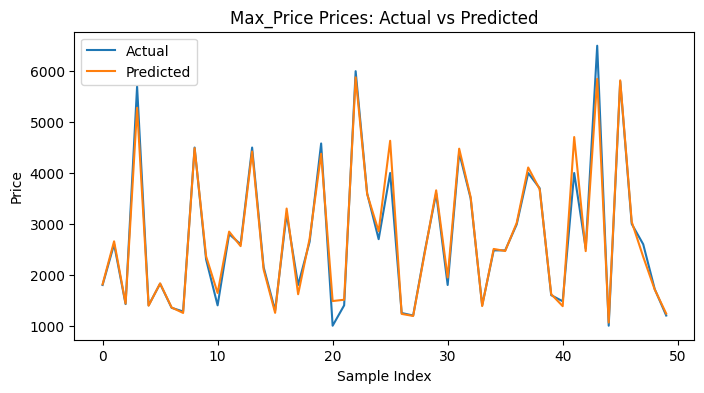

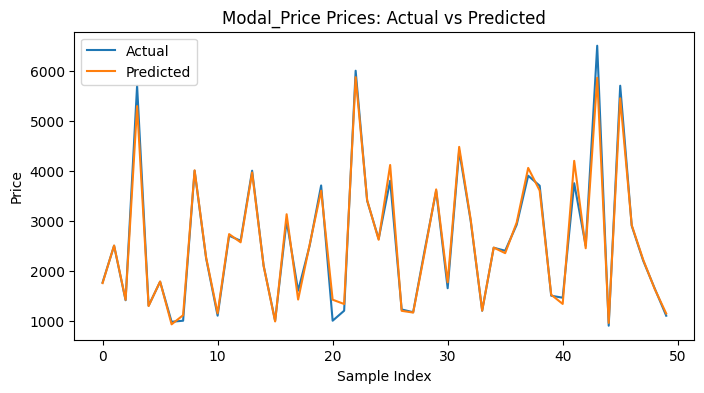

In [37]:
import matplotlib.pyplot as plt

for target in targets:
    plt.figure(figsize=(8,4))
    plt.plot(y_test[target].values[:50], label='Actual')
    plt.plot(predictions[target][:50], label='Predicted')
    plt.title(f'{target} Prices: Actual vs Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [40]:
import pandas as pd
import numpy as np

# Pick 5 random indices from the test set
random_indices = np.random.choice(len(X_test), size=5, replace=False)

# Prepare a DataFrame with original and predicted prices
sample_results = pd.DataFrame({
    'Original_Min_Price': y_test['Min_Price'].iloc[random_indices].values,
    'Predicted_Min_Price': predictions['Min_Price'][random_indices],
    'Original_Max_Price': y_test['Max_Price'].iloc[random_indices].values,
    'Predicted_Max_Price': predictions['Max_Price'][random_indices],
    'Original_Modal_Price': y_test['Modal_Price'].iloc[random_indices].values,
    'Predicted_Modal_Price': predictions['Modal_Price'][random_indices]
})

print(sample_results)


   Original_Min_Price  Predicted_Min_Price  Original_Max_Price  \
0              2225.0          2187.077148              2265.0   
1              2010.0          2048.760498              2100.0   
2              2380.0          2379.713623              2500.0   
3              1340.0          1345.274170              1400.0   
4              2600.0          2667.495605              3000.0   

   Predicted_Max_Price  Original_Modal_Price  Predicted_Modal_Price  
0          2268.123291                2240.0            2228.962891  
1          2146.688965                2050.0            2102.547363  
2          2482.494385                2400.0            2430.055420  
3          1389.907227                1360.0            1377.153442  
4          2906.452393                2800.0            2706.376221  
